<a href="https://colab.research.google.com/github/boernd/rl-workshop/blob/main/Kopie_von_Part4_DQN_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Background**
Reinforcement learning is a machine learning technique for solving problems by a feedback system (rewards and penalties) applied on an agent which operates in an environment and needs to move through a series of states in order to reach a pre-defined final state. A classical example is a rat (agent) which is trying to find the shortest route from a starting cell to a target cheese cell in a maze (environment). The agent is experimenting and exploiting past experiences (episodes) in order to achieve its goal. It may fail again and again, but hopefully, after lots of trial and error (rewards and penalties) it will arrive to the solution of the problem. The solution will be reached if the agent finds the optimal sequence of states in which the accumulated sum of rewards is maximal (in short, we lure the agent to accumulate a maximal reward, and while doing so, he actually solves our problem). Note that it may happen that in order to reach the goal, the agent will have to endure many penalties (negative rewards) on its way. For example, the rat in the above maze gets a small penalty for every legal move. The reason for that is that we want it to get to the target cell in the shortest possible path. However, the shortest path to the target cheese cell is sometimes long and winding, and our agent (the rat) may have to endure many penalties until he gets to the "cheese" (sometimes called "delayed reward").

# Maze Solving
Traditional maze puzzles have been used a lot in data structures and algorithms research and education. The well-known Dijkstra shortest path algorithm is still the most practical method for solving such puzzles, but due to their familiarity and intuititive nature, these puzzles are quite good for demonstrating and testing Reiforcement Learning techniques.

A simple maze consists of a rectangular grid of cells (usually square), a rat, and a "cheese" cell.

# Assumption
To keep it as simple as possible:

We will use small 10x10 mazes as examples
The cheese is always at the bottom right cell of the maze
We have two types of cells: free cells (white) and occupied cells (red or black).
The rat can start from any free cell and is allowed to travel on the free cells only

# Load Libraries
We will use the keras Python deep learning library on top of Google's Tensorflow version 0.12.1. We will need matplotlib module for drawing mazes.

In [ ]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

Our 10x10 maze can be easily coded as a 10x10 Numpy matrix

In [ ]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])

# Environment Description
A framework for an MDP (Markov Decision Process) consists of an environment and an agent which acts in this environment. In our case the environment is a classical square maze with three types of cells:



*   Occupied cells
*   Free cells
*   Target Cell (in which the cheese is located)


Our agent is a rat (or a mouse if you prefer) which is allowed to move only on free cells, and whose sole purpose in life is to get to the cheese.

In our model, the rat will be "encouraged" to find the shortest path to the target cell by a simple rewarding scheme:

1.   We have exactly 4 actions which we must encode as integers 0-3:

*   0 - left
*   1 - up
*   2 - right
*   3 - down

2.   Our rewards will be floating points ranging from -1.0 to 1.0.
3.   Each move from one state to the next state will be rewarded (the rat gets points) by a positive or a negative (penalty) amount.
4.   Each move from one cell to an adjacent cell will cost the rat -0.04 points. This should discourage the rat from wandering around and get to the cheese in the shortest route possible.
5.   The maximal reward of 1.0 points is given when the rat hits the cheese cell.
6.   An attempt to enter a blocked cell ("red" cell) will cost the rat -0.75 points! This is a severe penalty, so hopefully the rat will learn to avoid it completely. Note that an attempt to move to a blocked cell is invalid and will not be executed. But it will incur a -0.75 penalty if attempted.
7.   Same rule hold for an attempt to move outside the maze boundaries: **-0.8 points penalty**.
8.   The rat will be penelized by -0.25 points for any move to a cell which he has already visited. This is clealy a counter productive action that should not be taken at all.
9.   To avoid infinite loops and senseless wandering, the game is ended (**lose**) once the total reward of the rat is below the negative threshold: (-0.5 * maze.size). We assume that under this threshold, the rat has "lost its way" and already made too many errors from which he has learned enough, and should proceed to a new fresh game.

Here are our main constants:

In [ ]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

# Exploitation vs. Exploration
We already explained what min_reward and actions_dict are. The story of epsilon, also called exploration factor is part of the larger Q-learning story:

1.   The main objective of Q-training is to develope a policy  π  for navigating the maze successfully. Presumably, after playing hundreds of games, the agent (rat in our case) should attain a clear deterministic policy for how to act in every possible situation. Which action to take in every possible maze state?

2.   The term policy should be understood simply as a function  π  that takes a maze snapshot (envstate) as input and returns the action to be taken by the agent (rat in our case). The input consists of the full nxn maze cells state and the rat location.
***next action=π(state)***
 
3.   At start, we simply choose a completely random policy. Then we use it to play thousands of games from which we learn how to perfect it. Surely, at the early training stages, our policy  π  will yield lots of errors and cause us to lose many games, but our rewarding policy should provide feedback for it on how to improve itself. Our learning engine is going to be a simple feed-forward neural network which takes an environment state (maze cells) as input and yields a reward per action vector (see later for better description).

4.   In order to enhance the Q-learning process, we shall use two types of moves:

**Exploitation:** these are moves that our policy  π  dictates based on previous experiences. The policy function is used in about 90% of the moves before it is completed.

**Exploration:** in about 10% of the cases, we take a completely random action in order to acquire new experiences (and possibly meet bigger rewards) which our strategy function may not allow us to make due to its restrictive nature. Think of it as choosing a completey random new restaurant once in a while instead of choosing the routine restaurants that you already familiar with.

5.   The exploration factor epsilon is the the frequency level of how much exploration to do. It is usually set to 0.1, which roughly means that in one of every 10 moves the agent takes a completely random action. There are however many other usage schemes you can try (you can even tune epsilon during training!)

# The Qmaze Class

In [ ]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

# Presenting a maze
The rat is represented by a 50% gray level, and the cheese by a 90% gray level cell. We will use the term "enviroment" to describe the full image (with the rat and cheese thrown in). This is the standard agent/environment terminology used in most Reinforcement Learning discussions

In [ ]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [ ]:
maze = [
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
]

reward= -0.04


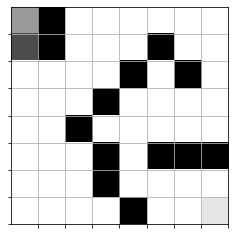

In [ ]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

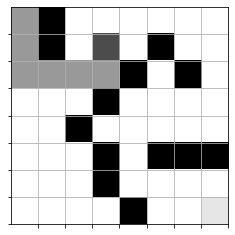

In [ ]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

Indeed, it is now very simple to write a fucntion for simulating a full game according to a given model (trained neural network). This function acceps the following three arguments:

1.   model - a trained neural network which calculates the next action
2.   qmaze - A Qmaze object
3.   rat_cell - the starting cell of the rat

In [ ]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

# Completion Check
For small mazes we can allow ourselves to perform a completion check in which we simulate all possible games and check if our model wins the all. This is not practical for large mazes as it slows down training significantly.

In [ ]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

# Markov Decision Process for Maze Environment
A Reinforcement Learning system consists of an environment and a dynamic agent which acts in this environment in finite discrete list of time steps.

1.   At every time step  t , the agent is entering a state  s , and needs to choose an action  a  from a fixed set of possible actions. The decision about which action to take should depend on the current state only (previous actions history is irrelevant). This is sometimes reffered to as MDP: Markov Decision Process (or shortly Markov Chain).

2.   The result of performing action  a  at time  t  will result in a transition from a current state  s  at time  t  to a new state  s′=T(s,a)  at time  t+1 , and an immediate reward  r=R(s,a)  (numerical value) which is collected by the agent after each action (could be called a "penalty" in case the reward is negative).  T  is usually calle the transition function, and  R  is the reward function:
*   s′=T(s,a)
*   r=R(s,a)
 
3.   The agent's goal is to collect the maximal total reward during a "game". The greedy policy of choosing the action that yields the highest immediate reward at state  s , may not lead to the best possible total reward as it may happend that after one "lucky" strike all the subsequent moves will yield poor rewards or even penalties. Therefore, selecting the optimal route is a real and difficult challenge (just as it is in life, delayed rewards are hard to get by).

The reward for every legal move is  −0.04  which is actually a "small penalty". The reason for this is that we want to minimize the rat's route to the cheese. The more the rat wonders around and wastes time, the less reward he gets. When the rat reaches the cheese cell, he gets the maximal reward of  1.0  (all rewards are ranging from  −1.0  to  1.0 ).

Note that each state consists of all the available cells information, including the rat location. In our Python code, each state is represented by a vector of length 64 (for an 8x8 maze) with gray values 0.0 to 1.0: occupied cells is 0.0, a free cell is 1.0, and the rat cell is 0.5. History (yellow cells) is not recorded since the next move should not depend on past moves!

4.   If our agent takes the action sequence (starting at state  s1  till the game end):  a1 ,  a2 ,  a3 , ...,  an , then the resulting total reward for this sequence is:

**A=R(s1,a1)+R(s2,a2)+⋯+R(sn,an)**
 
Our goal is to find a policy function  π  that maps a maze state  s  to an "optimal" action  a  that we should take in order to maximize our total reward  A . The policy  π  tells us what action to take in whatever state  s  we are in by simply applying it on the given state  s :
**action=π(s)**

5. Once we have a policy function  π , all we need to do is to follow it blindly:
a1s2a2⋯an=π(s1)=T(s1,a1)=π(s2)=⋯=π(sn−1)
 
So playing the maze is now becoming an automatic pilot flight. We simply ask  π  what to do in each state and we're guaranteed to end the game with the maximal reward.
6.   But how are we supposed to find  π ? From a game-theoretic point of view, it is know to be quite a difficult challenge, especially for large board games such as GO (for which no classical game theoretic solution is known).

**Q-Learning and Bellman Equation**

The trick that was used by startups such as Google DeepMind for finding  π  was to start with a different kind of function  Q(s,a)  called best utility function (and sometimes best quality function, from which the Q letter and Q-learning terms were coined).

---
The definition of  Q(s,a)  is simple:

Q(s,a)=the maximum total reward we can get by choosing action a in state s

---
At least for our maze solving, it is easy to be convinced that such function exists, although we have no idea how to compute it efficiently (except for going through all possible Markov chains that start at state  s , which is insanely inefficient). But it can also be proved mathematically for all similar Markov systems. Look for example in: https://webdocs.cs.ualberta.ca/~sutton/book/ebook/the-book.html

Once we have  Q(s,a)  at hand, finding a policy function is easy!
**π(s)=argmaxi=0,1,…,n−1Q(s,ai)**
 
That is: we calculate  **Q(s,ai)**  for all actions  ai ,  i=0,1,…,n−1  (where  n  is the number of actions), and select the action  ai  for which  Q(s,ai)  is maximal. This is obviously the way to go. But we do not have the function  Q(s,a)  yet ... how do we get it?

It turns out that the function  Q(s,a)  has a simple recursive property which characterizes it, and also helps to approximate it. It is called Bellman's Equation and it is obvious from first sight:

**Q(s,a)=R(s,a)+maxi=0,1,…,n−1Q(s′,ai),(where s′=T(s,a))**
 
In simple words: the value  Q(s,a)  is equal to the immediate reward  R(s,a)  plus the maximal value of  Q(s′,aj) , where  s′  is the next state and  ai  is an action.

In addition, Bellman's Equation is also a unique characterization of the best utility function. That is, if a function  Q(s,a)  satisfies the Bellman Equation then it must be the best utility function.



# Q-Training
The question now is how do we train our neural network  N ? The usual arrangement (as we've seen a lot) is to generate a sufficiently large dataset of  (e,q)  pairs, where  e  is an environment state (or maze state in our case), and  q=(q0,q1,…,qn−1)  are the correct actions q-values. To do this, we will have to simulate thousands of games and make sure that all our moves are optimal (or else our q-values may not be correct). This is of course too tedious, too hard, and impractical in most real life cases.

Deep learning startups (like Google DeepMind) came up with more practical and surprisingly elegant schemes for tackling this problem. We will explore one of them (thanks to Eder Santana post which included a small and clear demonstration).

We will generate our training samples from using the neural network  N  itself, by simulating hundreds or thousands of games. We will exploit the derived policy  π  (from the last section) to make 90% of our game moves (the other 10% of the moves are reserved for exploration). However we will set the target function of our neural network  N  to be the function in the right side of Bellman's equation! Assuming that our neural network  N  converges, it will define a function  Q(s,a)  which satisfies Bellman's equation, and therefore it must be the best utility function which we seek.

The training of  N  will be done after each game move by injecting a random selection of the most recent training samples to  N . Assuming that our game skill will get better in time, we will use only a small number of the most recent training samples. We will forget old samples (which are probably bad) and will delete them from memory.

In more detail: After each game move we will generate an episode and save it to a short term memory sequence. An episode is a tuple of 5 elements that we need for one training:

**episode = [envstate, action, reward, envstate_next, game_over]**

(a) envstate - environment state. In our maze case it means a full picture of the maze cells (the state of each cell including rat and chees location) To make it easier for our neural network, we squash the maze to a 1-dimensional vector that fits the networks input.

(b) action - one of the four actions that the rat can do to move on the maze:

     0 - left
     1 - up
     2 - right
     3 - down
(c) reward - is the reward received from the action

(d) envstate_next - this is the new maze environment state which resulted from the last action

(e) game_over - this is a boolean value (True/False) which indicates if the game is over or not. The game is over if the rat has reached the cheese cell (win), or of the rats has reached a negative reward limit (lose).

After each move in the game, we form this 5-elements episode and insert it to our memory sequence. In case that our memory sequence size grows beyond a fixed bound we delete elements from its tail to keep it below this bound.

The weights of network  N  are initialized with random values, so in the beginning  N  will produce awful results, but if our model parameters are chosen properly, it should converge to a solution of the Bellman Equation, and therefore later experiments are expected to be more truthful. Currently, building model that converge quickly seems to be very difficult and there is still lots of room for improvements in this issue.

# The Experience Class
This is the class in which we collect our game episodes (or game experiences) within a memory list. Note that its initialization methods need to get a

model - a neural network model
max_memory - maximeal length of episodes to keep. When we reach the maximal lenght of memory, each time we add a new episode, the oldest episode is deleted
discount factor - this is a special coefficient, usually denoted by  γ  which is required for the Bellman equation for stochastic environments (in which state transitions are probabilistic). Here is a more practical version of the Bellman equation:
Q(s,a)=R(s,a)+γ⋅maxi=0,…,n−1Q(s′,ai),(where s′=T(s,a))

In [ ]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

# The Q-Training Algorithm for Qmaze
Following is the algorithm fortraining a our neural network model to solve the maze. It accepts a keyword argument list. Here are the most significant options:

**n_epoch** - Number of training epochs

**max_memory** - Maximum number of game experiences we keep in memory (see the Experince class above)

**data_size** - Number of samples we use in each training epoch. This is the number episodes (or game experiences) which we randomly select from our experiences repository (again, see the Experience class above)


In [ ]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

# Building a Neural Network Model
Choosing the correct parameters for a suitable model is not easy and requires some experience and many experiments. In the case of a maze we found that:

The most suitable activation function is SReLU (the S-shaped relu)
Our optimizer is RMSProp
Our loss function is mse (Mean Squared Error).
We use two hidden layers, each of size equals to the maze size. The input layer has also the same size as the maze since it accepts the maze stae as input. The output layer size is the same as the number of actions (4 in our case), since its outputs the estimated q-value for each action. (we need to take the action with the maximal q-value for playing in the game).

In [ ]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# Small Q-test
Lets test our algorithm on the following small (7x7) maze

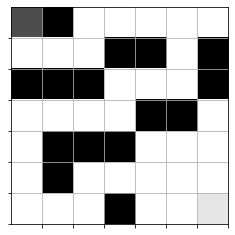

In [ ]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Qmaze(maze)
show(qmaze)

In [ ]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0234 | Episodes: 41 | Win count: 1 | Win rate: 0.000 | time: 57.0 seconds
Epoch: 001/14999 | Loss: 0.0078 | Episodes: 32 | Win count: 2 | Win rate: 0.000 | time: 122.8 seconds
Epoch: 002/14999 | Loss: 0.0113 | Episodes: 4 | Win count: 3 | Win rate: 0.000 | time: 130.9 seconds
Epoch: 003/14999 | Loss: 0.0108 | Episodes: 9 | Win count: 4 | Win rate: 0.000 | time: 149.3 seconds


KeyboardInterrupt: ignored